### Ingest Data and Import Libraries

In [107]:
import pandas as pd
import os
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import random
from dataclasses import dataclass

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer

import gensim
from gensim import corpora, similarities
from gensim.models import Word2Vec, LdaMulticore, TfidfModel, CoherenceModel
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import LsiModel,LdaModel

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE, MDS
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.naive_bayes import MultinomialNB

import scipy.cluster.hierarchy

from IPython.display import display, HTML

from typing import List, Callable, Dict

In [42]:
nltk.download('stopwords',quiet=True)
nltk.download('wordnet',quiet=True)
nltk.download('punkt',quiet=True)
nltk.download('omw-1.4',quiet=True)

True

In [43]:
#not sure I need this - try next time I run what happens
import pkg_resources
pkg_resources.require("gensim<=3.8.3");

Cleaning functions

In [106]:
def clean_doc(doc): 
    #split document into individual words
    tokens=doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 4]
    #lowercase all words
    tokens = [word.lower() for word in tokens]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]         
    # word stemming    
    #ps=PorterStemmer()
    #tokens=[ps.stem(word) for word in tokens]
    # lemmatize
    wnl = WordNetLemmatizer()
    tokens=[wnl.lemmatize(word) for word in tokens]
    return tokens

def final_processed_text(doc):
    #this is a function to join the processed text back
    ' '.join(doc)
    return doc

def tfidf(corpus, titles, ngram_range):
    #this is a function to create the tfidf matrix
    Tfidf=TfidfVectorizer(ngram_range=(1,1))

    #fit the vectorizer using final processed documents.  The vectorizer requires the 
    #stiched back together document.

    TFIDF_matrix=Tfidf.fit_transform(corpus)     

    #creating dataframe from TFIDF Matrix
    words = Tfidf.get_feature_names_out()
    matrix=pd.DataFrame(TFIDF_matrix.toarray(), columns=Tfidf.get_feature_names(), index=titles)
    return matrix ,words

def One_Hot(variable):
    #this is a function to one hot encode the classes
    LE=LabelEncoder()
    LE.fit(variable)
    Label1=LE.transform(variable)
    OHE=OneHotEncoder()
    labels=OHE.fit_transform(Label1.reshape(-1,1)).toarray()
    return labels

In [99]:
#read in class corpus csv into python
data=pd.read_csv(r'https://raw.githubusercontent.com/djp840/MSDS_453_Public/main/MSDS453_ClassCorpus/MSDS453_Sec57_2202_ClassCorpus_v2.csv')

In [46]:
data.head()

Doc_ID               DSI_Title Student Name Genre of Movie  \
0       1  EMU_Doc1_TheConjuring3          EMU         Horror   
1       2  EMU_Doc2_TheConjuring3          EMU         Horror   
2       3  EMU_Doc3_TheConjuring3          EMU         Horror   
3       4  EMU_Doc4_TheConjuring3          EMU         Horror   
4       5  EMU_Doc5_TheConjuring3          EMU         Horror   

  Review Type (pos or neg)      Movie Title  \
0                 Negative  The Conjuring 3   
1                 Positive  The Conjuring 3   
2                 Positive  The Conjuring 3   
3                 Positive  The Conjuring 3   
4                 Positive  The Conjuring 3   

                                                Text  
0  I must admit that when I sat down to watch the...  
1  While The Conjuring franchise has stood as one...  
2  We’re well into the world and the lore of the ...  
3  James Wan's 2013 feature The Conjuring was som...  
4  Two Conjuring films and several spinoffs estab...

### EDA 

In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Doc_ID                    200 non-null    int64 
 1   DSI_Title                 200 non-null    object
 2   Student Name              200 non-null    object
 3   Genre of Movie            200 non-null    object
 4   Review Type (pos or neg)  200 non-null    object
 5   Movie Title               200 non-null    object
 6   Text                      200 non-null    object
dtypes: int64(1), object(6)
memory usage: 11.1+ KB


In [100]:
#adding two columns to the dataframe to store the processed text and tokenized text
data['processed_text'] = data['Text'].apply(lambda x: clean_doc(x))

#creating final processed text variables for matrix creation
final_processed_text = [' '.join(x) for x in data['processed_text'].tolist()]
titles = data['DSI_Title'].tolist()
processed_text = data['processed_text'].tolist()

In [101]:
data.head()

Doc_ID               DSI_Title Student Name Genre of Movie  \
0       1  EMU_Doc1_TheConjuring3          EMU         Horror   
1       2  EMU_Doc2_TheConjuring3          EMU         Horror   
2       3  EMU_Doc3_TheConjuring3          EMU         Horror   
3       4  EMU_Doc4_TheConjuring3          EMU         Horror   
4       5  EMU_Doc5_TheConjuring3          EMU         Horror   

  Review Type (pos or neg)      Movie Title  \
0                 Negative  The Conjuring 3   
1                 Positive  The Conjuring 3   
2                 Positive  The Conjuring 3   
3                 Positive  The Conjuring 3   
4                 Positive  The Conjuring 3   

                                                Text  \
0  I must admit that when I sat down to watch the...   
1  While The Conjuring franchise has stood as one...   
2  We’re well into the world and the lore of the ...   
3  James Wan's 2013 feature The Conjuring was som...   
4  Two Conjuring films and several spinoffs estab...   

                                      processed_text  
0  [admit, watch, addit, conjur, franchis, harbor...  
1  [conjur, franchis, stood, success, impress, ho...  
2  [world, warren, lorrain, fiction, version, rea...  
3  [jame, featur, conjur, someth, special, haunt,...  
4  [conjur, film, sever, spinoff, establish, subs...

In [102]:
tfidf_matrix, tfidf_words = tfidf(final_processed_text, titles, ngram_range = (1,1))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [103]:
tfidf_matrix

abandon  abash    abduct  abdulmateen  abel  \
EMU_Doc1_TheConjuring3               0.0    0.0  0.000000          0.0   0.0   
EMU_Doc2_TheConjuring3               0.0    0.0  0.000000          0.0   0.0   
EMU_Doc3_TheConjuring3               0.0    0.0  0.000000          0.0   0.0   
EMU_Doc4_TheConjuring3               0.0    0.0  0.000000          0.0   0.0   
EMU_Doc5_TheConjuring3               0.0    0.0  0.000000          0.0   0.0   
...                                  ...    ...       ...          ...   ...   
JLU_Doc6_JamesBondCasinoRoyale       0.0    0.0  0.027458          0.0   0.0   
JLU_Doc7_JamesBondCasinoRoyale       0.0    0.0  0.000000          0.0   0.0   
JLU_Doc8_JamesBondCasinoRoyale       0.0    0.0  0.000000          0.0   0.0   
JLU_Doc9_JamesBondCasinoRoyale       0.0    0.0  0.000000          0.0   0.0   
JLU_Doc10_JamesBondCasinoRoyale      0.0    0.0  0.000000          0.0   0.0   

                                 aberr  abhorr  abid      abil  abject  ...  \
EMU_Doc1_TheConjuring3             0.0     0.0   0.0  0.000000     0.0  ...   
EMU_Doc2_TheConjuring3             0.0     0.0   0.0  0.000000     0.0  ...   
EMU_Doc3_TheConjuring3             0.0     0.0   0.0  0.000000     0.0  ...   
EMU_Doc4_TheConjuring3             0.0     0.0   0.0  0.000000     0.0  ...   
EMU_Doc5_TheConjuring3             0.0     0.0   0.0  0.000000     0.0  ...   
...                                ...     ...   ...       ...     ...  ...   
JLU_Doc6_JamesBondCasinoRoyale     0.0     0.0   0.0  0.019833     0.0  ...   
JLU_Doc7_JamesBondCasinoRoyale     0.0     0.0   0.0  0.000000     0.0  ...   
JLU_Doc8_JamesBondCasinoRoyale     0.0     0.0   0.0  0.000000     0.0  ...   
JLU_Doc9_JamesBondCasinoRoyale     0.0     0.0   0.0  0.000000     0.0  ...   
JLU_Doc10_JamesBondCasinoRoyale    0.0     0.0   0.0  0.000000     0.0  ...   

                                 òpostmodern  òthatõ  òthi  òundefin  òwere  \
EMU_Doc1_TheConjuring3                   0.0     0.0   0.0       0.0    0.0   
EMU_Doc2_TheConjuring3                   0.0     0.0   0.0       0.0    0.0   
EMU_Doc3_TheConjuring3                   0.0     0.0   0.0       0.0    0.0   
EMU_Doc4_TheConjuring3                   0.0     0.0   0.0       0.0    0.0   
EMU_Doc5_TheConjuring3                   0.0     0.0   0.0       0.0    0.0   
...                                      ...     ...   ...       ...    ...   
JLU_Doc6_JamesBondCasinoRoyale           0.0     0.0   0.0       0.0    0.0   
JLU_Doc7_JamesBondCasinoRoyale           0.0     0.0   0.0       0.0    0.0   
JLU_Doc8_JamesBondCasinoRoyale           0.0     0.0   0.0       0.0    0.0   
JLU_Doc9_JamesBondCasinoRoyale           0.0     0.0   0.0       0.0    0.0   
JLU_Doc10_JamesBondCasinoRoyale          0.0     0.0   0.0       0.0    0.0   

                                 òzeroó  ógustav  überproduc  überstarman  \
EMU_Doc1_TheConjuring3              0.0      0.0         0.0          0.0   
EMU_Doc2_TheConjuring3              0.0      0.0         0.0          0.0   
EMU_Doc3_TheConjuring3              0.0      0.0         0.0          0.0   
EMU_Doc4_TheConjuring3              0.0      0.0         0.0          0.0   
EMU_Doc5_TheConjuring3              0.0      0.0         0.0          0.0   
...                                 ...      ...         ...          ...   
JLU_Doc6_JamesBondCasinoRoyale      0.0      0.0         0.0          0.0   
JLU_Doc7_JamesBondCasinoRoyale      0.0      0.0         0.0          0.0   
JLU_Doc8_JamesBondCasinoRoyale      0.0      0.0         0.0          0.0   
JLU_Doc9_JamesBondCasinoRoyale      0.0      0.0         0.0          0.0   
JLU_Doc10_JamesBondCasinoRoyale     0.0      0.0         0.0          0.0   

                                 þórarinn  
EMU_Doc1_TheConjuring3                0.0  
EMU_Doc2_TheConjuring3                0.0  
EMU_Doc3_TheConjuring3                0.0  
EMU_Doc4_TheConjuring3                0.0  
EMU_Doc5_TheConjuring3       

In [104]:
print(len(tfidf_words))
type(tfidf_words)

10680


numpy.ndarray

### Modeling

#### LSA (Latent Semantic Analysis)

In [119]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):

    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    index = similarities.MatrixSimilarity(lsamodel[doc_term_matrix])

    return lsamodel,dictionary,index

def lsa(tfidf_matrix, terms, n_components):
    #this is a function to execute lsa.  inputs to the function include the tfidf matrix and
    #the desired number of components.
    
    LSA = TruncatedSVD(n_components=10, n_iter=100)
    LSA.fit(tfidf_matrix)

    for i, comp in enumerate(LSA.components_):
        terms_comp = zip(terms, comp)
        sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
        print("Topic "+str(i)+": ")
        for t in sorted_terms:
            print(t[0])

def plot_lsa(number_of_topics, words):

    model,dictionary,index=create_gensim_lsa_model(processed_text,number_of_topics,words)

    for doc in processed_text:
        vec_bow = dictionary.doc2bow(doc)
        vec_lsi = model[vec_bow]  # convert the query to LSI space
        sims = index[vec_lsi] # perform a similarity query against the corpus

    fig, ax = plt.subplots(figsize=(30, 30))
    cax = ax.matshow(index, interpolation='nearest')
    ax.grid(True)
    plt.xticks(range(len(processed_text)), titles, rotation=90);
    plt.yticks(range(len(processed_text)), titles);
    fig.colorbar(cax)
    plt.show()
    return model

[(0, '0.483*"movie" + 0.206*"character" + 0.160*"story" + 0.133*"first" + 0.122*"cruella" + 0.119*"film" + 0.114*"would" + 0.114*"scene" + 0.109*"action" + 0.109*"world"'), (1, '0.736*"cruella" + -0.267*"movie" + 0.157*"baroness" + 0.156*"estella" + 0.150*"story" + 0.146*"stone" + 0.131*"character" + 0.122*"fashion" + 0.119*"thompson" + 0.110*"villain"')]


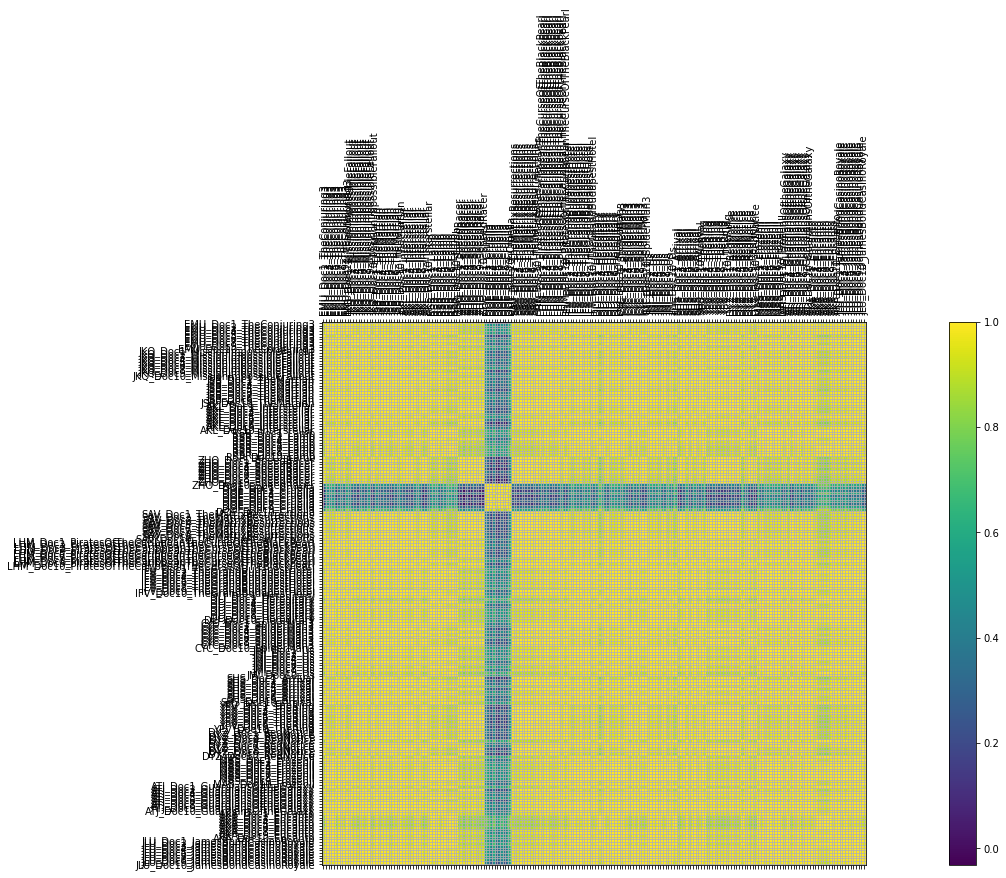

In [54]:
model_2topic_10words = plot_lsa(2,10)

[(0, '0.483*"movie" + 0.206*"character" + 0.160*"story" + 0.133*"first" + 0.122*"cruella" + 0.119*"film" + 0.114*"would" + 0.114*"scene" + 0.109*"action" + 0.109*"world"'), (1, '-0.736*"cruella" + 0.267*"movie" + -0.157*"baroness" + -0.156*"estella" + -0.150*"story" + -0.146*"stone" + -0.131*"character" + -0.122*"fashion" + -0.119*"thompson" + -0.110*"villain"'), (2, '-0.462*"anderson" + 0.401*"movie" + -0.284*"budapest" + -0.277*"grand" + -0.266*"hotel" + -0.192*"gustave" + -0.147*"andersonõs" + 0.109*"cruella" + -0.109*"world" + -0.101*"film"'), (3, '-0.357*"movie" + 0.289*"mission" + 0.220*"impossible" + 0.208*"cruise" + 0.202*"casino" + -0.201*"anderson" + 0.201*"royale" + 0.184*"action" + 0.182*"vesper" + 0.182*"fallout"'), (4, '0.385*"matrix" + 0.192*"mission" + 0.190*"action" + 0.185*"impossible" + -0.183*"casino" + 0.183*"cruise" + -0.182*"royale" + 0.171*"resurrection" + -0.171*"family" + -0.167*"vesper"'), (5, '0.419*"matrix" + 0.255*"casino" + 0.251*"royale" + 0.232*"vesper"

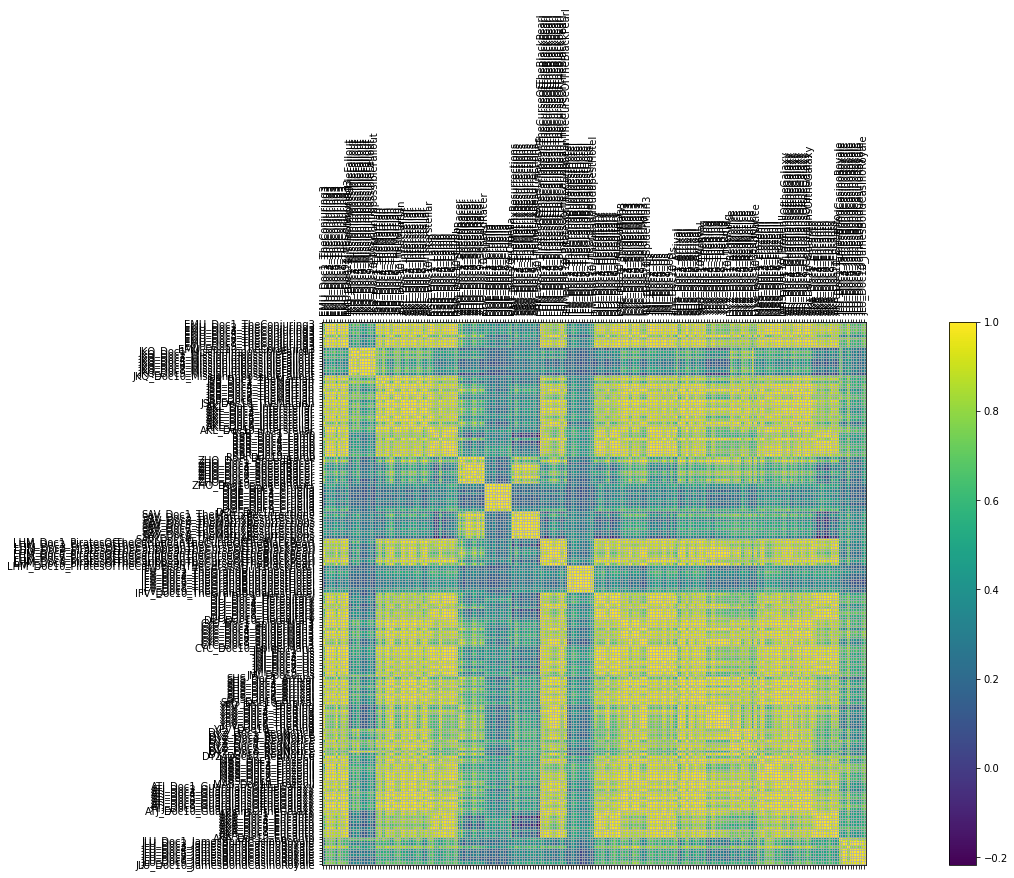

In [55]:
model_6topic_10words = plot_lsa(6, 10)

[(0, '-0.434*"movi" + -0.191*"charact" + -0.150*"stori" + -0.124*"first" + -0.123*"play" + -0.117*"cruella" + -0.117*"make" + -0.114*"film" + -0.106*"would" + -0.106*"scene"'), (1, '0.731*"cruella" + -0.279*"movi" + 0.152*"estella" + 0.145*"baro" + 0.144*"stone" + 0.143*"stori" + 0.122*"charact" + 0.118*"fashion" + 0.116*"thompson" + 0.114*"villain"'), (2, '-0.446*"movi" + 0.429*"anderson" + 0.266*"budapest" + 0.258*"grand" + 0.249*"hotel" + 0.182*"gustav" + -0.140*"cruella" + 0.137*"andersonõ" + 0.104*"film" + 0.102*"world"'), (3, '-0.324*"movi" + 0.265*"mission" + -0.254*"anderson" + 0.200*"imposs" + 0.197*"casino" + 0.187*"royal" + 0.187*"cruis" + 0.177*"vesper" + 0.164*"fallout" + 0.163*"action"'), (4, '0.433*"matrix" + 0.224*"wachowski" + -0.201*"famili" + 0.200*"resurrect" + 0.184*"action" + 0.170*"mission" + 0.161*"imposs" + 0.156*"cruis" + -0.155*"horror" + 0.147*"speed"'), (5, '-0.302*"royal" + -0.301*"casino" + -0.270*"matrix" + -0.269*"vesper" + 0.223*"mission" + 0.198*"impo

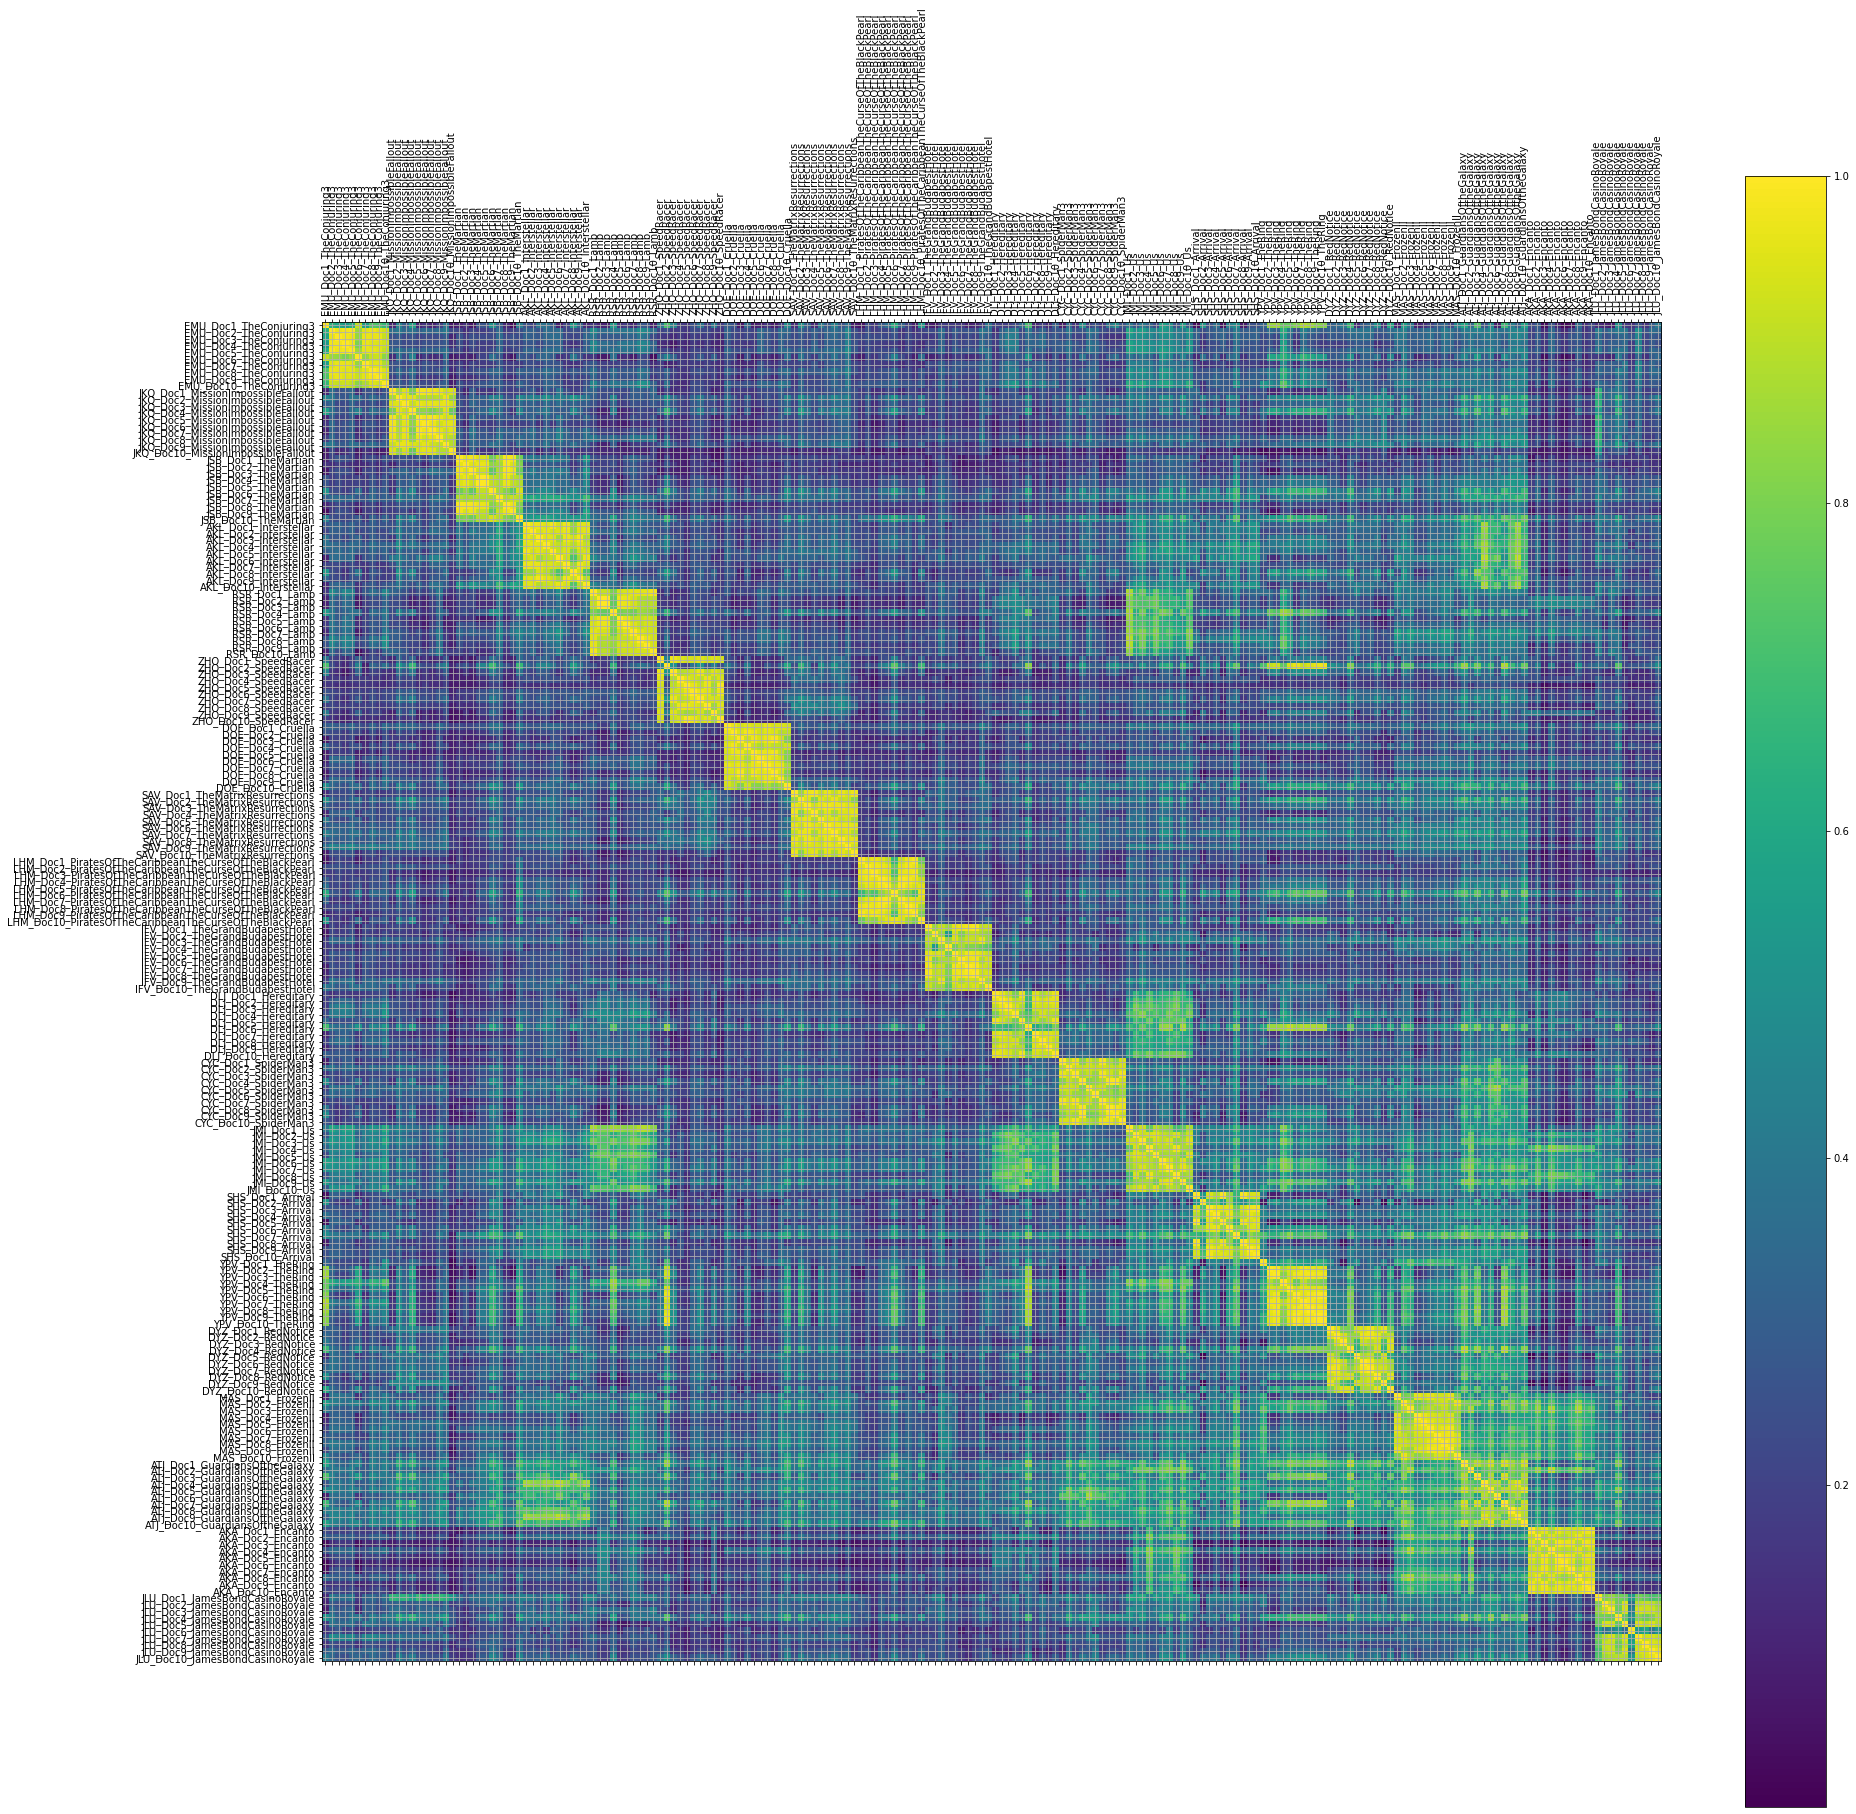

In [120]:
model_20topic_10words =plot_lsa(20, 10)

In [57]:
topics = [6, 2, 10]
coherence_values = []
for t in topics:
    lsamodel,dictionary,index = create_gensim_lsa_model(processed_text,t,10)


    coherence_model_lsa = CoherenceModel(model=lsamodel, dictionary=dictionary, texts=processed_text, coherence='c_v')
    coherence_lsa = coherence_model_lsa.get_coherence()
    coherence_values.append(coherence_lsa)

    
coherence ={'6 topic 10 words':coherence_values[0],
           '2 topic 10 words': coherence_values[1],
           '20 topic 10 words':coherence_values[2]}   

print(coherence)

[(0, '0.483*"movie" + 0.206*"character" + 0.160*"story" + 0.133*"first" + 0.122*"cruella" + 0.119*"film" + 0.114*"would" + 0.114*"scene" + 0.109*"action" + 0.109*"world"'), (1, '-0.736*"cruella" + 0.267*"movie" + -0.157*"baroness" + -0.156*"estella" + -0.149*"story" + -0.146*"stone" + -0.131*"character" + -0.122*"fashion" + -0.119*"thompson" + -0.110*"villain"'), (2, '0.462*"anderson" + -0.401*"movie" + 0.284*"budapest" + 0.277*"grand" + 0.266*"hotel" + 0.192*"gustave" + 0.147*"andersonõs" + -0.109*"cruella" + 0.108*"world" + 0.101*"film"'), (3, '-0.357*"movie" + 0.289*"mission" + 0.221*"impossible" + 0.208*"cruise" + 0.202*"casino" + -0.201*"anderson" + 0.201*"royale" + 0.184*"action" + 0.182*"vesper" + 0.182*"fallout"'), (4, '0.385*"matrix" + 0.192*"mission" + 0.189*"action" + 0.185*"impossible" + -0.183*"casino" + 0.183*"cruise" + -0.182*"royale" + 0.171*"resurrection" + -0.171*"family" + -0.167*"vesper"'), (5, '-0.419*"matrix" + -0.255*"casino" + -0.251*"royale" + -0.232*"vesper" +

#### LDA

In [58]:
def create_gensim_lda_model(doc_clean,number_of_topics,words):

    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    ldamodel = LdaModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)
    # train model
    print(ldamodel.print_topics(num_topics=number_of_topics, num_words=words))
    index = similarities.MatrixSimilarity(ldamodel[doc_term_matrix])
    return ldamodel,dictionary,index,doc_term_matrix

def lda(tfidf_matrix, terms, topics = 3, num_words = 10):
    #this is a function to perform lda on the tfidf matrix.  function varibales include:
    #tfidf matrix, desired number of topic, and number of words per topic.

    topics = 3
    num_words = 10
    lda = LatentDirichletAllocation(n_components=topics).fit(tfidf_matrix)

    topic_dict = {}
    for topic_num, topic in enumerate(lda.components_):
        topic_dict[topic_num] = " ".join([terms[i]for i in topic.argsort()[:-num_words - 1:-1]])

    print(topic_dict)

def word2vec(processed_text, size = 100):
    #This is a function to generate the word2vec matrix. Input parameters include the 
    #tokenized text and matrix size
    
    #word to vec
    model_w2v = Word2Vec(processed_text, size=100, window=5, min_count=1, workers=4)

    #join all processed DSI words into single list
    processed_text_w2v=[]
    for i in processed_text:
        for k in i:
            processed_text_w2v.append(k)

    #obtian all the unique words from DSI
    w2v_words=list(set(processed_text_w2v))

    #can also use the get_feature_names() from TFIDF to get the list of words
    #w2v_words=Tfidf.get_feature_names()

    #empty dictionary to store words with vectors
    w2v_vectors={}

    #for loop to obtain weights for each word
    for i in w2v_words:
        temp_vec=model_w2v.wv[i]
        w2v_vectors[i]=temp_vec

    #create a final dataframe to view word vectors
    w2v_df=pd.DataFrame(w2v_vectors).transpose()
    print(w2v_df)
    return w2v_df

In [74]:
number_of_topics=20
words=7

[(0, '0.015*"movie" + 0.006*"cruella" + 0.005*"story" + 0.004*"character" + 0.004*"horror" + 0.003*"speed" + 0.003*"thing"'), (1, '0.010*"movie" + 0.004*"would" + 0.003*"family" + 0.003*"character" + 0.003*"anderson" + 0.003*"story" + 0.003*"first"'), (2, '0.006*"movie" + 0.005*"story" + 0.004*"first" + 0.004*"could" + 0.004*"action" + 0.004*"matrix" + 0.004*"character"'), (3, '0.008*"movie" + 0.005*"character" + 0.004*"cruella" + 0.004*"first" + 0.003*"scene" + 0.003*"story" + 0.002*"world"'), (4, '0.005*"movie" + 0.004*"family" + 0.003*"story" + 0.003*"moment" + 0.003*"character" + 0.002*"thing" + 0.002*"world"'), (5, '0.009*"movie" + 0.004*"first" + 0.003*"scene" + 0.003*"character" + 0.003*"peter" + 0.003*"film" + 0.002*"matrix"'), (6, '0.008*"movie" + 0.004*"character" + 0.004*"action" + 0.003*"first" + 0.003*"scene" + 0.003*"film" + 0.003*"cruella"'), (7, '0.005*"movie" + 0.005*"family" + 0.004*"story" + 0.004*"character" + 0.003*"first" + 0.003*"film" + 0.003*"thing"'), (8, '0.0

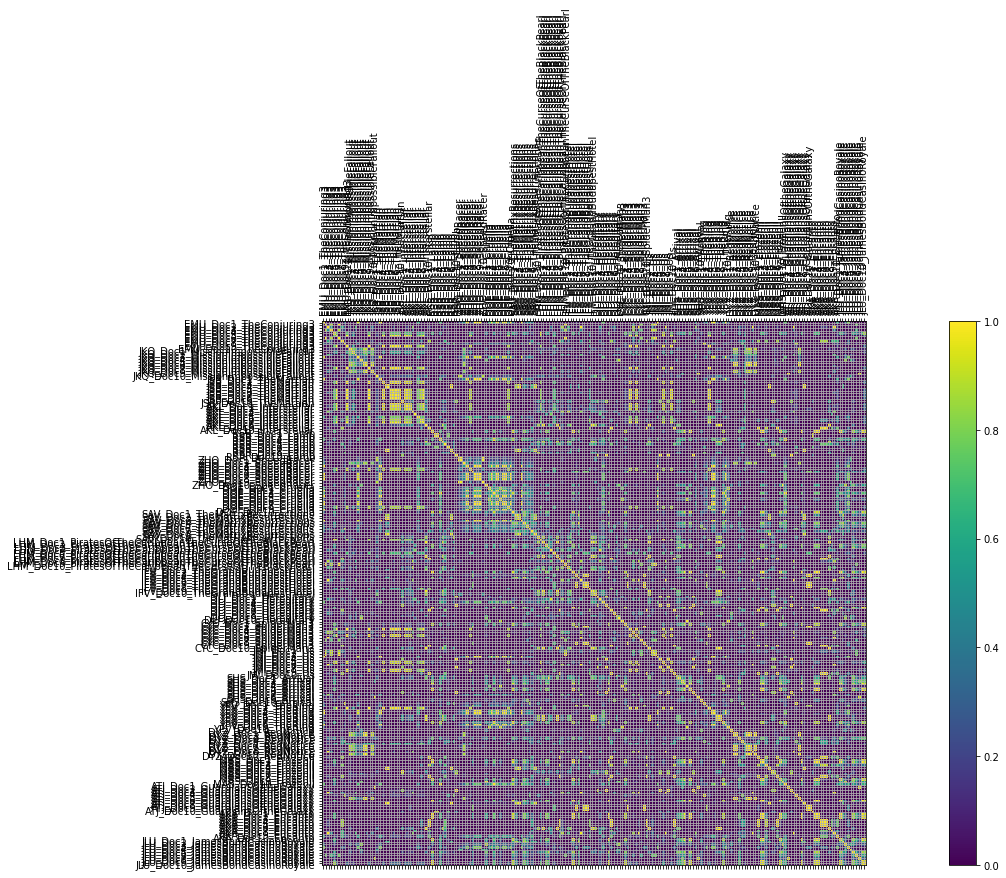

In [75]:
model2,dictionary2,index2,doctermmatrix2=create_gensim_lda_model(processed_text,number_of_topics, words)

for doc in processed_text:
    vec_bow2 = dictionary2.doc2bow(doc)
    vec2 = model2[vec_bow2]  # convert the query to embedded space
    sims2 = index2[vec2]  # perform a similarity query against the corpus
    #print(list(enumerate(sims2)))  

fig, ax = plt.subplots(figsize=(30, 10))
cax = ax.matshow(index2, interpolation='nearest')
ax.grid(True)
plt.xticks(range(len(processed_text)), titles, rotation=90);
plt.yticks(range(len(processed_text)), titles);
fig.colorbar(cax)
plt.show()

In [61]:
topics = [6, 2, 10]
coherence_values = []
for t in topics:
    ldamodel,dictionary,index, matrix = create_gensim_lda_model(processed_text,t,10)


    coherence_model_lda = CoherenceModel(model=ldamodel, dictionary=dictionary, texts=processed_text, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_values.append(coherence_lda)

    
coherence ={'6 topic 10 words':coherence_values[0],
           '2 topic 10 words': coherence_values[1],
           '20 topic 10 words':coherence_values[2]}   

print(coherence)

[(0, '0.007*"movie" + 0.005*"family" + 0.004*"character" + 0.004*"story" + 0.002*"film" + 0.002*"horror" + 0.002*"thing" + 0.002*"world" + 0.002*"scene" + 0.002*"action"'), (1, '0.009*"movie" + 0.004*"matrix" + 0.004*"first" + 0.003*"story" + 0.003*"character" + 0.003*"horror" + 0.003*"never" + 0.003*"film" + 0.003*"anderson" + 0.002*"world"'), (2, '0.009*"movie" + 0.004*"character" + 0.004*"story" + 0.003*"would" + 0.003*"first" + 0.003*"film" + 0.003*"thing" + 0.002*"audience" + 0.002*"speed" + 0.002*"world"'), (3, '0.011*"movie" + 0.005*"character" + 0.003*"family" + 0.003*"story" + 0.003*"would" + 0.003*"first" + 0.003*"scene" + 0.003*"cruella" + 0.002*"something" + 0.002*"world"'), (4, '0.011*"movie" + 0.004*"character" + 0.004*"action" + 0.003*"story" + 0.003*"first" + 0.003*"world" + 0.002*"cruella" + 0.002*"would" + 0.002*"film" + 0.002*"scene"'), (5, '0.009*"movie" + 0.005*"character" + 0.004*"cruella" + 0.003*"story" + 0.003*"first" + 0.003*"film" + 0.002*"scene" + 0.002*"wou

### Clustering Model Research

#### K-Means

In [62]:
def k_means(titles, tfidf_matrix, k):
    
    #this is a function to generate the k-means output using the tfidf matrix.  Inputs 
    #to the function include: titles of text, processed text, and desired k value. 
    #Returns dataframe indicating cluster number per document

    km = KMeans(n_clusters=k, random_state =89)
    km.fit(tfidf_matrix)
    clusters = km.labels_.tolist()

    Dictionary={'Doc Name':titles, 'Cluster':clusters,  'Text': final_processed_text}
    frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])
    #dictionary to store clusters and respective titles
    cluster_title={}

    #note doc2vec clusters will not have individual words due to the vector representation
    #is based on the entire document not indvidual words. As a result, there won't be individual
    #word outputs from each cluster.   
    for i in range(k):
        temp=frame[frame['Cluster']==i]
        temp_title_list=[]
        for title in temp['Doc Name']:
            temp_title_list.append(title)
        cluster_title[i]=temp_title_list

    return cluster_title,clusters,frame

def plot_tfidf_matrix(cluster_title,clusters,TFIDF_matrix):
    # convert two components as we're plotting points in a two-dimensional plane
    # "precomputed" because we provide a distance matrix
    # we will also specify `random_state` so the plot is reproducible.

    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
    dist = 1 - cosine_similarity(TFIDF_matrix)
    pos = mds.fit_transform(dist)  # shape (n_components, n_samples)
    xs, ys = pos[:, 0], pos[:, 1]


    #set up colors per clusters using a dict.  number of colors must correspond to K
    cluster_colors = {0: 'black', 1: 'grey', 2: 'blue', 3: 'rosybrown', 4: 'firebrick', 
                      5:'red', 6:'darksalmon', 7:'sienna'}

    #set up cluster names using a dict.  
    cluster_dict=cluster_title

    #create data frame that has the result of the MDS plus the cluster numbers and titles
    df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=range(0,len(clusters)))) 

    #group by cluster
    groups = df.groupby('label')

    fig, ax = plt.subplots(figsize=(20,20)) # set size
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    #iterate through groups to layer the plot
    #note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
    for name, group in groups:
        
        r = random.random()
        b = random.random()
        g = random.random()
        color = (r, g, b)
        
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
                label=cluster_dict[name], color=color, 
                mec='none')
        ax.set_aspect('auto')
        ax.tick_params(\
            axis= 'x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelbottom='on')
        ax.tick_params(\
            axis= 'y',         # changes apply to the y-axis
            which='both',      # both major and minor ticks are affected
            left='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelleft='on')

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 30})      #show legend with only 1 point

In [63]:
cluster_title,clusters,k_means_df = k_means(titles, tfidf_matrix, k =4)

In [64]:
cluster_title

{0: ['EMU_Doc1_TheConjuring3',
  'EMU_Doc2_TheConjuring3',
  'EMU_Doc3_TheConjuring3',
  'EMU_Doc4_TheConjuring3',
  'EMU_Doc5_TheConjuring3',
  'EMU_Doc6_TheConjuring3',
  'EMU_Doc7_TheConjuring3',
  'EMU_Doc8_TheConjuring3',
  'EMU_Doc9_TheConjuring3',
  'EMU_Doc10_TheConjuring3',
  'JKQ_Doc1_MissionImpossibleFallout',
  'JKQ_Doc2_MissionImpossibleFallout',
  'JKQ_Doc3_MissionImpossibleFallout',
  'JKQ_Doc4_MissionImpossibleFallout',
  'JKQ_Doc5_MissionImpossibleFallout',
  'JKQ_Doc6_MissionImpossibleFallout',
  'JKQ_Doc7_MissionImpossibleFallout',
  'JKQ_Doc8_MissionImpossibleFallout',
  'JKQ_Doc9_MissionImpossibleFallout',
  'JKQ_Doc10_MissionImpossibleFallout',
  'JSB_Doc1_TheMartian',
  'JSB_Doc2_TheMartian',
  'JSB_Doc3_TheMartian',
  'JSB_Doc4_TheMartian',
  'JSB_Doc5_TheMartian',
  'JSB_Doc6_TheMartian',
  'JSB_Doc7_TheMartian',
  'JSB_Doc8_TheMartian',
  'JSB_Doc9_TheMartian',
  'JSB_Doc10_TheMartian',
  'AKL_Doc1_Interstellar',
  'AKL_Doc2_Interstellar',
  'AKL_Doc3_Interste

In [65]:
k_means_df

Cluster                         Doc Name  \
0          0           EMU_Doc1_TheConjuring3   
1          0           EMU_Doc2_TheConjuring3   
2          0           EMU_Doc3_TheConjuring3   
3          0           EMU_Doc4_TheConjuring3   
4          0           EMU_Doc5_TheConjuring3   
..       ...                              ...   
195        0   JLU_Doc6_JamesBondCasinoRoyale   
196        0   JLU_Doc7_JamesBondCasinoRoyale   
197        0   JLU_Doc8_JamesBondCasinoRoyale   
198        0   JLU_Doc9_JamesBondCasinoRoyale   
199        0  JLU_Doc10_JamesBondCasinoRoyale   

                                                  Text  
0    admit watch addition conjuring franchise harbo...  
1    conjuring franchise stood successful impressiv...  
2    world warren lorraine fictional version realli...  
3    james feature conjuring something special haun...  
4    conjuring film several spinoffs established su...  
..                                                 ...  
195  people smarter infinitely invested woman franc...  
196  daniel craig enters picture casino royale come...  
197  watching everything nothing documentary barbar...  
198  year today november james casino royale releas...  
199  daniel craig connery casino royale thats thing...  

[200 rows x 3 columns]

In [66]:
plot_tfidf_matrix(cluster_title,clusters,tfidf_matrix)

In [67]:
labels = data['Review Type (pos or neg)'].apply(lambda x: 0 if x.lower().split(' ')[0] == 'negative' else 1)
print(labels)

0      0
1      1
2      1
3      1
4      1
      ..
195    1
196    1
197    1
198    1
199    1
Name: Review Type (pos or neg), Length: 200, dtype: int64


#### SVM, Naive Bayes, Random Forest

In [68]:
def classifiers(x, y, model_type, cv = 3):
    
    #this function is to fit 3 different model scenarios.  Support vector machines, logistic regressions, naive bayes.
    #svm = Support vector machin
    #logistic = Logistic regression
    #naive_bayes = Naive Bayes Multinomial
    
    #can define cv value for cross validation.
    
    #function returns the train test split scores of each model.
    
    if model_type == 'svm':
        print("svm")
        model = SVC()

    elif model_type == 'logistic':
        print("logistic")
        model = LogisticRegression()

    elif model_type == 'naive_bayes':
        print("naive_bayes")
        model = MultinomialNB()
    
    elif model_type == 'randomforest':
        print("randomforest")
        model = RandomForestClassifier()

    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    accy = accuracy_score(y_test, predictions) 
    return accy

In [69]:
# SVM
classifiers(tfidf_matrix, labels, 'svm')

svm


0.3939393939393939

In [70]:
# Naive Bayes
classifiers(tfidf_matrix, labels, 'naive_bayes')

naive_bayes


0.3939393939393939

In [71]:
# Random Forest
classifiers(tfidf_matrix, labels, 'randomforest')

randomforest


0.5454545454545454